# AG3 - Actividad Guiada 3

Nombre: Carlos Javier Bravo Intriago

Link:   https://colab.research.google.com/drive/1KJYOEgvLdYHFngyX9lAbgp-pwRASvd-Y?usp=sharing

Github: https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG3



# Carga de librerias

In [1]:
!pip install requests
!pip install tabulate>=0.9 networkx>=3.0
!pip install tsplib95 --no-deps
!pip install deprecated

# Importe de librerias

In [2]:
import gzip
from typing import List, Tuple, Union, Literal, Callable, Dict
import math
import os
import random
import shutil
import urllib.request

import tsplib95
import numpy as np

## Métodos Auxiliares y algunas definiciones necesarias

In [3]:
NumericType = Union[int, float]
NodeType = int
EdgeType = Tuple[NodeType, NodeType]
SolutionType = List[NodeType]
TSProblemType = tsplib95.models.Problem

def download_tsp_file(url: str, filename: str) -> None:
    # Descarga como archivo temporal
    local_path, headers = urllib.request.urlretrieve(url, filename + ".temp")
    mime_type = headers.get_content_type()
    # Descomprimir si es formato gzip
    if "gzip" in mime_type or local_path.endswith(".gz"):
        with gzip.open(local_path, 'rb') as f_in:
            with open(filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(local_path)
    # Caso contrario renombra el archivo temporal
    else:
        os.replace(local_path, filename)

# Carga de los datos del problema

Documentación :
* https://web.archive.org/web/http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/
* https://web.archive.org/web/http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
* https://tsplib95.readthedocs.io/en/stable/pages/usage.html
* https://tsplib95.readthedocs.io/en/v0.6.1/modules.html
* https://pypi.org/project/tsplib95/
* https://github.com/mastqe/tsplib/tree/master

Se descarga el fichero de datos ya sea en Matriz de adyacencia o en formato
Euclidiano

In [4]:
# Matriz Adyacencia swiss42 problem (Staedte Schweiz/Fricker)
file = "swiss42.tsp"
download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/swiss42.tsp", file)

# Coordenadas Euclidianas 51-city problem (Christofides/Eilon)
# file = "eil51.tsp"
# download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/eil51.tsp", file)

# Coordenadas Euclidianas - 48 capitals of the US (Padberg/Rinaldi)
# file = "att48.tsp"
# download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp", file)

_Carga de datos y generación de objeto problem_

In [5]:
tsp_problem: tsplib95.models.Problem = tsplib95.load(file)

nodes: List[NodeType] = list(tsp_problem.get_nodes())
edges: List[EdgeType] = list(tsp_problem.get_edges())


<div style="flex: 0 0 300px; text-align: center;">
        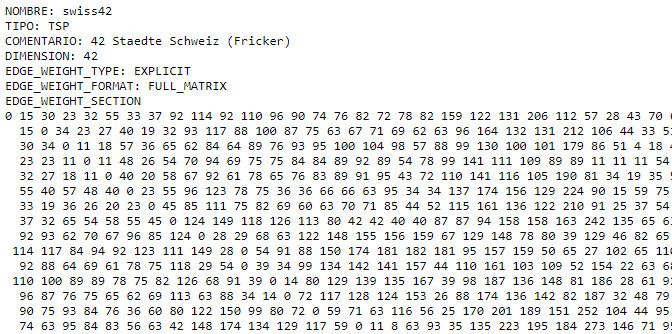
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Visualizacion del problema swiss.42.tsp</p>
    </div>
</div>


Probamos algunas funciones del objeto problem
Distancia entre nodos

In [6]:
tsp_problem.get_weight(4, 1)

27

_Para ver todas las funciones, véase la documentación: https://tsplib95.readthedocs.io/en/v0.6.1/modules.html_

# Funcionas básicas

In [8]:
def crear_solucion(nodos: List[NodeType]) -> SolutionType:
    """
    Se genera una solución aleatoria con comienzo en el nodo 0
    :param nodos: Lista de nodos
    :return: Lista de nodos en posiciones aleatorias sin repetición
    """
    solucion = [nodos[0]]
    for _ in nodos[1:]:
        solucion = solucion + [
            random.choice(list(set(nodos) - {nodos[0]} - set(solucion)))]
    return solucion

def distancia(a: int, b: int, problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia entre dos nodos
    :param a: Nodo a
    :param b: Nodo b
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    return problem.get_weight(a, b)

def distancia_total(solucion: List[int], problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia total de una trayectoria/solución
    :param solucion: Lista de Nodos
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    distancia_total = 0
    for i in range(len(solucion) - 1):
        distancia_total += distancia(solucion[i], solucion[i + 1], problem)
    return distancia_total + distancia(solucion[len(solucion) - 1], solucion[0], problem)


sol_temporal = crear_solucion(nodes)

print("Solución Aleatoria:", sol_temporal)
print("Distancia:", distancia_total(sol_temporal, tsp_problem))

Solución Aleatoria: [0, 9, 8, 5, 34, 36, 40, 7, 29, 13, 21, 19, 33, 2, 22, 18, 39, 23, 38, 25, 14, 30, 28, 6, 3, 31, 41, 24, 35, 17, 37, 26, 20, 15, 27, 1, 10, 16, 11, 12, 4, 32]
Distancia: 4924


# BÚSQUEDA ALEATORIA

Esta búsqueda explora el espacio de soluciones de manera aleatoria, una
analogía sería como buscar una aguja en un pajar cogiendo paja al azar y
volviéndola a tirar. Este es un método _ingenuo_.

In [8]:
def busqueda_aleatoria(
        problem: TSProblemType,
        n: int
) -> Tuple[SolutionType, NumericType]:
    """
    Busca de manera aleatoria en N iteraciones alguna mejor solución.
    :param problem: Instancia de tsplib95.models.Problem
    :param n: el número de iteraciones
    :return:
    """
    nodos = list(problem.get_nodes())
    mejor_solucion = []
    # Inicializamos con un valor alto
    mejor_distancia = float('inf')
    # Criterio de parada: repetir N veces pero podemos incluir otros
    for i in range(n):
        solucion = crear_solucion(nodos)  # Genera una solucion aleatoria
        distancia = distancia_total(solucion, problem)  # Calcula el valor objetivo(distancia total)
        if distancia < mejor_distancia:  # Compara con la mejor obtenida hasta ahora
            mejor_solucion = solucion
            mejor_distancia = distancia
    return mejor_solucion, mejor_distancia

# Búsqueda aleatoria con 50000 iteraciones
solucion_inicial, distancia_inicial = busqueda_aleatoria(tsp_problem, 50000)
print("Mejor solución:", solucion_inicial)
print("Distancia     :", distancia_inicial)

Mejor solución: [0, 14, 37, 15, 29, 23, 3, 20, 21, 40, 41, 39, 6, 30, 31, 24, 9, 34, 28, 2, 27, 18, 13, 25, 11, 7, 8, 22, 38, 5, 35, 36, 17, 16, 32, 33, 4, 10, 12, 1, 26, 19]
Distancia     : 3666


# BÚSQUEDA LOCAL

Este criterio de búsqueda es un método heurístico de mejora iterativa que
explora el vecindario de una solución candidata mediante operaciones de
perturbación local (tales como swap, 2-opt, shuffle e insertion). Su enfoque
se basa estrictamente en la intensificación aceptando únicamente movimientos
que maximicen o minimicen el coste objetivo.

### Sobre el método `get_swap_delta`

Se pretende simplificar el cálculo de la distancia total de la solución que
tiene complejidad $O(N)$, basándose en operaciones más simples debido al
intercambio de elementos. Se contempla dos posibles casos:

1. **Caso Adyacente ($j = i + 1$):** Los nodos están pegados ($\cdots \to P
\to A \to B \to N \cdots$). Al intercambiarlos ($\cdots \to P \to B \to A \to N
\cdots$), la arista central $(A, B)$ se convierte en $(B, A)$. Asumiendo
simetría, se cancelan. Solo cambian las conexiones exteriores:
$$ \Delta = (Cost(P, B) + Cost(A, N)) - (Cost(P, A) + Cost(B, N)) $$

2. **Caso No Adyacente (Disjuntos):** Los nodos están separados. Se rompen
las 4 aristas incidentes a $A$ y $B$ y se reconectan cruzadas. Sea $A$
rodeado por $(P_a, N_a)$ y $B$ rodeado por $(P_b, N_b)$:
$$ \Delta = [Cost(P_a, B) + Cost(B, N_a) + Cost(P_b, A) + Cost(A, N_b)] - [Cost(P_a, A) + Cost(A, N_a) + Cost(P_b, B) + Cost(B, N_b)] $$

### Sobre el método `get_two_opt_delta`:
Este cálculo asume simetría en la matriz de distancias ($d_{ij} = d_{ji}$).
Al invertir el segmento $i \dots j$, la longitud interna del sub-camino
permanece constante, reduciendo la complejidad del cálculo de $O(N)$ a $O(1)$
. Para instancias asimétricas (ATSP), se debe calcular la `distancia_total` de
recorrer el segmento en sentido inverso.


In [9]:
def swap_nodes(i: int, j: int, solution: SolutionType) -> SolutionType:
    """
    Intercambia la posición del nodo `i` y nodo `j`\n
    >>> swap_nodes(i=1, j=4, solution=['A', 'B', 'C', 'D', 'E', 'F'])
    >>> ['A', 'E', 'C', 'D', 'B', 'F']
    :param i: Posición Nodo i
    :param j: Posición Nodo j
    :param solution: Solución a la que se aplicara el intercambio
    :return: Nueva solución
    """
    _solution = list(solution)
    _solution[i], _solution[j] = _solution[j], _solution[i]
    return _solution

def get_swap_delta(
        i: int,
        j: int,
        solution: SolutionType,
        problem: TSProblemType
) -> NumericType:
    """
    Calcula la variación del costo total `Δ` al intercambiar los nodos
    en las posiciones i y j.\n
    Realiza una operación de complejidad constante O(1) calculando
    únicamente la diferencia local de las aristas incidentes afectadas, sin
    recorrer la ruta completa.\n
    Δ = Costoₐᵣᵢₛₜₐₛ_ₙᵤₑᵥₐₛ - Costoₐᵣᵢₛₜₐₛ_ᵣₑₘₒᵥᵢₔₐₛ
    :param i: Posición Nodo i
    :param j: Posición Nodo j
    :param solution: Solución a la que se aplicara el intercambio
    :param problem: Instancia de tsplib95.models.Problem
    :return: delta
    """
    n = len(solution)
    a_prev, a, a_next = solution[i-1], solution[i], solution[(i+1)%n]
    b_prev, b, b_next = solution[j-1], solution[j], solution[(j+1)%n]

    if j == i + 1: # Nodos adyacentes
        return (problem.get_weight(a_prev, b) + problem.get_weight(a, b_next)) - \
                (problem.get_weight(a_prev, a) + problem.get_weight(b, b_next))
    else:
        return (problem.get_weight(a_prev, b) + problem.get_weight(b, a_next) +
                 problem.get_weight(b_prev, a) + problem.get_weight(a, b_next)) - \
                (problem.get_weight(a_prev, a) + problem.get_weight(a, a_next) +
                 problem.get_weight(b_prev, b) + problem.get_weight(b, b_next))

def two_opt(i: int, j: int, solution: SolutionType) -> SolutionType:
    """
    Invierte los nodos dentro del intervalo o rango [i,j].
    >>> two_opt(i=1, j=4, solution=['A', 'B', 'C', 'D', 'E', 'F'])
    >>> ['A', 'E', 'D', 'C', 'B', 'F']
    :param i: Posición Nodo i
    :param j: Posición Nodo j
    :param solution: Solución a la que se aplicara el intercambio
    :return: Nueva solución
    """
    if i>j:
        raise ValueError("i es mayor que j")
    return solution[:i] + solution[i:j+1][::-1] + solution[j + 1:]

def get_two_opt_delta(
        i: int,
        j: int,
        solution: SolutionType,
        problem: TSProblemType
) -> NumericType:
    """
    Calcula la variación del costo total `Δ` al aplicar una inversion de
    segmento entre los índices i y j.\n
    Esta operación es de complejidad constante $O(1)$ para problemas simétricos,
    ya que la inversión del sub-camino interno conserva su longitud total. El
    cálculo se limita a los puntos de corte del grafo.\n
    Δ = [dist(i-1, j) + dist(i, j+1)] - [dist(i-1, i) + dist(j, j+1)]
    :param i: Posición Nodo i
    :param j: Posición Nodo j
    :param solution: Solución a la que se aplicara el intercambio
    :param problem: Instancia de tsplib95.models.Problem
    :return: delta
    """
    n = len(solution)
    if i == 0 and j == n - 1:
        return 0
    a, b = solution[i-1], solution[i]
    c, d = solution[j], solution[(j + 1) % n]
    return (problem.get_weight(a, c) + problem.get_weight(b, d)) - \
            (problem.get_weight(a, b) + problem.get_weight(c, d))

def shuffle(i: int, j: int, solution: SolutionType) -> SolutionType:
    """
    Del intervalo o rango [i, j], baraja los nodos dentro de ese intervalo\n
    >>> shuffle(i=1, j=4, solution=['A', 'B', 'C', 'D', 'E', 'F'])
    >>> ['A', 'E', 'C', 'B', 'D', 'F']
    :param i: Posición Nodo i
    :param j: Posición Nodo j
    :param solution: Solución a la que se aplicara el intercambio
    :return: Nueva solución
    """
    subarray = solution[i : j + 1]
    shuffled_subarray = random.sample(subarray, len(subarray))
    return solution[:i] + shuffled_subarray + solution[j + 1:]

def insertion(i: int, j: int, solution: SolutionType) -> SolutionType:
    """
    Toma el elemento de la posición `i` y lo inserta en la posición `j`
    >>> insertion(i=1, j=4, solution=['A', 'B', 'C', 'D', 'E', 'F'])
    >>> ['A', 'C', 'D', 'E', 'B', 'F']
    :param i: posición o índice del elemento a retirar
    :param j: posición o índice donde se desea insertar
    :param solution:
    :return:
    """
    _solution = list(solution)
    node_for_move = _solution.pop(i)
    _solution.insert(j, node_for_move)
    return _solution

strategies: Dict[str, Callable[[int, int, SolutionType], SolutionType]] = {
    "swap": swap_nodes,
    "2-opt": two_opt,
    "shuffle": shuffle,
    "insertion": insertion
}

delta_callback = {
    "swap": get_swap_delta,
    "2-opt": get_two_opt_delta,
}

In [10]:
def generar_vecina(
        solucion: SolutionType,
        problem: TSProblemType,
        variant: Literal["swap", "2-opt", "shuffle"] = "swap",
) -> Tuple[SolutionType, NumericType]:
    """
    Generador de soluciones vecinas: 2-opt (intercambiar 2 nodos) Si hay N
    nodos se generan (N-1)x(N-2)/2 soluciones.\n
    Se puede modificar para aplicar otros generadores distintos que 2-opt
    :param solucion: Lista de nodos
    :param problem: Instancia de tsplib95.models.Problem
    :param variant: Estrategia para generar la vecina: Por defecto "swap"
    :return:
    """
    mejor_solucion = list(solucion)
    mejor_distancia = distancia_total(solucion, problem)
    n = len(solucion)
    variant_callback = strategies[variant]
    es_simetrico = hasattr(problem, 'type') and problem.type == 'TSP'

    for i in range(1, n - 1):
        for j in range(i + 1, n):
            # Complejidad de estimación de distancia O(1)
            # La ventaja de esta estimación es que se puede hacer antes de
            # ejecutar la estrategia de cambio de nodos, pero es válido
            # únicamente para grafos simétricos y la operacion 2-opt o la
            # operacion swap
            if es_simetrico and variant == "2-opt":
                delta = get_two_opt_delta(i, j, mejor_solucion, problem)
            elif variant == "swap":
                delta = get_swap_delta(i, j, mejor_solucion, problem)
            else:
                delta = None
            if delta is not None:
                if mejor_distancia + delta < mejor_distancia:
                    mejor_distancia = mejor_distancia + delta
                    mejor_solucion = variant_callback(i, j, mejor_solucion)
            else:
                # Complejidad de estimación de distancia O(N)
                vecina = variant_callback(i, j, mejor_solucion)
                # Se evalúa la nueva solución ...
                distancia_vecina = distancia_total(vecina, problem)
                # ... Para guardarla si mejora las anteriores
                if distancia_vecina < mejor_distancia:
                    mejor_distancia = distancia_vecina
                    mejor_solucion = vecina
    return mejor_solucion, mejor_distancia

print("Distancia Solución Inicial:", distancia_inicial)
soluciones = [
    generar_vecina(solucion_inicial, tsp_problem),
    generar_vecina(solucion_inicial, tsp_problem, variant="2-opt"),
    generar_vecina(solucion_inicial, tsp_problem, variant="shuffle"),
]
print("Distancia Mejor Solución Local con Swap:", soluciones[0][1])
print("Distancia Mejor Solución Local con 2-OPT:", soluciones[1][1])
print("Distancia Mejor Solución Local con Shuffle:", soluciones[2][1])

Distancia Solución Inicial: 3666
Distancia Mejor Solución Local con Swap: 1977
Distancia Mejor Solución Local con 2-OPT: 1661
Distancia Mejor Solución Local con Shuffle: 2763


In [11]:
# Elegimos la menor solucion entre las 3 variantes (usualmente suele ser 2-opt)
nueva_solucion, nueva_distancia = min(soluciones, key=lambda x: x[1])
nueva_distancia

1661

# Búsqueda Local(iteraciones):

In [12]:
def busqueda_local(
        solucion_inicial: SolutionType,
        problem: TSProblemType,
        variant: Literal["swap", "2-opt", "shuffle"] = "swap",
        verbose: bool = False
) -> Tuple[SolutionType, NumericType]:
    """
    Búsqueda Local(iteraciones):\n
    * Sobre el operador de vecindad 2-opt(función generar_vecina)\n
    * Sin criterio de parada, se para cuando no es posible mejorar.
    :param solucion_inicial: Lista de nodos
    :param problem: Instancia de tsplib95.models.Problem
    :param variant: Estrategia para generar la vecina: Por defecto "swap"
    :param verbose:
    :return:
    """

    #Generar una solucion inicial de referencia(aleatoria)
    solucion_referencia = list(solucion_inicial)
    mejor_distancia = distancia_total(solucion_referencia, problem)

    iteracion = 0  # Un contador para saber las iteraciones que hacemos
    while True:
        iteracion += 1  # Incrementamos el contador

        # Obtenemos la mejor vecina y la evaluamos para ver si mejoramos
        # respecto a lo encontrado hasta el momento
        nueva_solucion, distancia_vecina = generar_vecina(solucion_referencia, problem, variant)
        # Si no mejoramos hay que terminar. Hemos llegado a un minimo local
        # (según nuestro operador de vecindad 2-opt)
        if distancia_vecina < mejor_distancia:
            # mejor_solucion = copy.deepcopy(vecina)
            solucion_referencia = nueva_solucion  #Guarda la mejor solución encontrada
            mejor_distancia = distancia_vecina

        else:
            if verbose:
                print(
                    "En la iteración ", iteracion,
                    ", la mejor solución encontrada es:", solucion_referencia
                )
                print("Distancia: ", mejor_distancia)
            return solucion_referencia, mejor_distancia


mejor_solucion, mejor_distancia = busqueda_local(nueva_solucion, tsp_problem, variant="2-opt", verbose=True)

En la iteración  2 , la mejor solución encontrada es: [0, 32, 34, 33, 20, 35, 36, 31, 17, 37, 15, 16, 14, 7, 19, 13, 18, 12, 11, 25, 10, 41, 23, 9, 40, 24, 21, 39, 22, 38, 30, 29, 8, 28, 27, 2, 3, 4, 26, 5, 6, 1]
Distancia:  1373


# Búsqueda local con entornos Variables (VNS)

Esta propuesta se basa en la idea de _agitar_ (shaking) que se ha
interpretado para este caso en concreto como agregar una perturbación para evitar
el estancamiento en mínimos locales inherentes al operador 2-opt.

El código actual se basa en la solución para la Búsqueda por Entornos
Variables (VNS) propuesta por [[1](#ref1)], con distintos niveles de
intensidad que controlan dinámicamente la diversificación del espacio de
búsqueda y la preservación de las estructuras de las rutas previamente
optimizadas.

El nivel más bajo de perturbación (nivel 0) únicamente hace un intercambio de
2 nodos aleatorios.

Desde el nivel 1 al nivel 3 se _barajea_ a un segmento
proporcional al nivel elegido ($0.1 \times intensidad$)



In [13]:
def perturbar(
        solucion: SolutionType,
        intensidad:Literal[0,1,2,3]
) -> SolutionType:
    """
    Perturba a la solución según el nivel de `intensidad` de la perturbación
    deseada.\n
    Arbitrariamente se ha elegido 4 niveles de intensidad:\n
    intensidad=0: swap a dos nodos \n
    intensidad=1: barajeo de un segmento pequeño (10% de la ruta) \n
    intensidad=2: barajeo de un segmento mediano (20% de la ruta) \n
    intensidad=3: barajeo de un segmento grande (30% de la ruta) \n
    :param solucion:
    :param intensidad:
    :return:
    """
    n = len(solucion)
    if intensidad == 0:
        i, j = random.sample(range(n), 2)
        return swap_nodes(i, j, solucion)
    subsegment = max(2, int(n * 0.1 * intensidad))
    if subsegment > n:
        subsegment = n
    i = random.randint(0, n - subsegment)
    j = i + subsegment - 1
    return shuffle(i, j, solucion)


def busqueda_local_con_entornos_variables(
        solucion: SolutionType,
        problem: TSProblemType,
        max_iter: int = 100,
        verbose: bool = False
) -> Tuple[SolutionType, NumericType]:
    solucion_actual = list(solucion)
    mejor_distancia = distancia_total(solucion_actual, problem)
    k_max = 3
    iteracion = 0

    while iteracion <= max_iter:
        k = 0
        while k <= k_max and iteracion <= max_iter:
            iteracion += 1
            posible_candidata = perturbar(solucion_actual, k)
            candidata_optimizada, distancia_candidata = busqueda_local(posible_candidata, problem, variant="2-opt")

            if distancia_candidata < mejor_distancia:
                solucion_actual = candidata_optimizada
                mejor_distancia = distancia_candidata
                k = 0
                if verbose:
                    print(
                        "En la iteración ", iteracion,
                        ", la mejor solución encontrada es:", solucion_actual
                    )
                    print("Distancia: ", mejor_distancia)
            else:
                k += 1
    return solucion_actual, mejor_distancia

mejor_solucion, mejor_distancia = busqueda_local_con_entornos_variables(
    mejor_solucion, tsp_problem, 150, True
)

# Soluciones que llevan a un coste de 1273 para swiss42.tsp
# [0, 32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 41, 23, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1]
# [0, 32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 21, 40, 24, 39, 22, 38, 30, 29, 28, 2, 27, 3, 4, 6, 1]
# [0, 32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 41, 23, 40, 24, 21, 39, 22, 38, 30, 29, 28, 2, 27, 3, 4, 6, 1]
# [0, 32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 21, 40, 24, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1]
# [0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 38, 22, 39, 24, 40, 21, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31, 36, 35, 20, 33, 34, 32]
# [15, 37, 7, 17, 31, 36, 35, 20, 33, 34, 32, 0, 1, 6, 4, 3, 27, 2, 28, 29, 30, 38, 22, 39, 24, 40, 21, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16]
# [22, 39, 21, 24, 40, 23, 41, 9, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31, 36, 35, 20, 33, 34, 32, 0, 1, 6, 4, 3, 27, 2, 28, 29, 30, 38]
# [32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 41, 23, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1, 0]
# [36, 35, 20, 33, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 38, 22, 39, 21, 24, 40, 23, 41, 9, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31]
# [37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 41, 23, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1, 0, 32, 34, 33, 20, 35, 36, 31, 17, 7]

# Soluciones que llevan un coste de 10628 para att48.tsp
# [1, 9, 40, 15, 12, 11, 13, 25, 14, 23, 3, 22, 16, 41, 34, 29, 2, 26, 4, 35, 45, 10, 24, 42, 5, 48, 39, 32, 21, 47, 20, 33, 46, 36, 30, 43, 17, 27, 19, 37, 6, 28, 7, 18, 44, 31, 38, 8]


En la iteración  3 , la mejor solución encontrada es: [0, 32, 34, 33, 20, 35, 36, 31, 17, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 41, 23, 9, 40, 24, 21, 39, 22, 38, 30, 29, 8, 28, 27, 2, 3, 4, 6, 1, 7]
Distancia:  1326
En la iteración  17 , la mejor solución encontrada es: [0, 32, 34, 33, 20, 35, 36, 31, 17, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1, 7]
Distancia:  1285
En la iteración  25 , la mejor solución encontrada es: [36, 35, 20, 33, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 38, 22, 39, 21, 24, 40, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31]
Distancia:  1274
En la iteración  48 , la mejor solución encontrada es: [36, 35, 20, 33, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 38, 22, 39, 21, 24, 40, 23, 41, 9, 8, 10, 25, 11, 12, 18, 26, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31]
Distancia:  1273


# SIMULATED ANNEALING

El **Recocido Simulado** es una metaheurística probabilística inspirada en el
proceso físico de recocido de metales, donde un material se calienta y luego
se enfría lentamente para alcanzar una estructura cristalina de mínima
energía (estado óptimo).

A diferencia de la Búsqueda Local, que tiende a estancarse en óptimos locales
por aceptar únicamente mejoras, el Recocido Simulado permite escapar de estas
"trampas" aceptando temporalmente soluciones que empeoran la función objetivo.

## Generación de Vecindad:
Es el mecanismo que define el conjunto de soluciones candidatas
accesibles desde una solución actual mediante la aplicación de un
operador de movimiento o perturbación local. La elección del operador no solo
afecta la velocidad, sino la "suavidad" del recorrido por el paisaje de
búsqueda: un movimiento suave permite descender gradualmente hacia el mínimo,
mientras que un movimiento brusco puede destruir el progreso previo.

### Vecindad Aleatoria:
Este operador selecciona dos ciudades al azar en la ruta y intercambia sus
posiciones. Aunque computacionalmente ligero, es un movimiento
_"brusco/destructivo"_ desde el punto de vista topológico, ya que rompe
cuatro enlaces de la ruta original. Se utiliza principalmente para
diversificación brusca.

### Vecindad 2-Opt:
Consiste en eliminar dos aristas no adyacentes y reconectar los nodos
resultantes invirtiendo el sentido del sub-segmento intermedio. Supone una
generación de vecindad más _suave_ manteniendo la coherencia de los vecinos
dentro del segmento invertido.

### Vecindad por Inserción:
Extrae un nodo de su posición actual (i) y la reinserta en otra posición
arbitraria (j). A diferencia del 2-opt, este movimiento no invierte el orden
de los nodos intermedios. Es la variante más suave para correcciones
puntuales, ya que permite mover un nodo mal ubicado sin alterar el orden ni
el sentido del resto de la secuencia.

### Una propuesta híbrida experimental:
_Incorporado a este entregable por sugerencia técnica del asistente de IA
Generativa (Gemini) para mejorar suavidad al generar vecindades óptimas._

Se aplica una estrategia probabilística combinando las dos propuestas más
_suaves_ en lo referente a la generación de vecindad. Se propone la siguiente
distribución (de manera arbitraria o experimental):
* 80% 2-opt: Para resolver cruces y optimizar la forma general.
* 20% Inserción: Para reubicar nodos aislados.

Esta mezcla promete balancear (al menos experimentalmente se ha observado
aquello) la corrección estructural (2-opt) con la precisión local
(Inserción), evitando que el algoritmo se estanque en configuraciones que un
solo operador no podría resolver.

## Estrategias de Enfriamiento:
El esquema de enfriamiento es el mecanismo que regula el descenso de la
temperatura $T$, determinando cuánto tiempo dedica el algoritmo a la
exploración global frente a la intensificación local.

### Esquema Geométrico o Descenso Exponencial:
Es la estrategia clásica y la más extendida en la literatura básica del Recocido Simulado debido a su simplicidad.
$$
T_{k+1}=\alpha \cdot T_k
$$
Donde típicamente $0.8≤\alpha ≤0.99$. Este método genera un decaimiento
predecible, pero puede resultar inflexible: enfría con la misma "agresividad"
tanto al inicio (cuando se necesita caos) como al final (cuando se necesita
precisión).
### Estrategia de enfriamiento de Lundy-Mees:
_Incorporado a este entregable por sugerencia técnica del asistente de IA
Generativa (Gemini) para mejorar la convergencia en etapas finales._

Este esquema, propuesto por [[2](#ref2)], plantea un descenso no lineal que
ajusta la velocidad de enfriamiento según la magnitud de la temperatura actual:
$$
T_{k+1}=\frac{T_k}{1+\beta \cdot T_k}
$$
A diferencia del esquema geométrico, esta fórmula provoca un descenso rápido
cuando T es alta (evitando el desperdicio de cómputo en búsquedas aleatorias
excesivas) y, crucialmente, ralentiza el enfriamiento de forma extrema cuando
T se acerca a cero. Esto permite una fase de "recocido lento" o fine-tuning
mucho más exhaustiva en las iteraciones finales, aumentando la probabilidad
de encontrar el óptimo global en instancias complejas del TSP.

In [14]:
def genera_vecina_aleatorio(
        solucion: SolutionType,
        problem: TSProblemType
) -> Tuple[SolutionType, NumericType]:
    """
    Generador de 1 solución vecina 2-opt 100% aleatoria (intercambiar 2 nodos)\n
    Mejorable eligiendo otra forma de elegir una vecina.
    :param solucion:
    :return:
    """
    #Se eligen dos nodos aleatoriamente
    i, j = sorted(random.sample(range(1, len(solucion)), 2))
    #Devuelve una nueva solución pero intercambiando los dos nodos elegidos al azar
    _solucion = swap_nodes(i, j, solucion)
    delta = get_swap_delta(i, j, _solucion, problem)
    return _solucion, delta


def probabilidad(T: float, d: float) -> bool:
    """
    Función de probabilidad para aceptar peores soluciones
    :param T: Temperatura
    :param d:
    :return:
    """
    if d < 0: return True
    if T <= 1e-9: return False
    return random.random() < math.exp(-d / T)


def bajar_temperatura(T: float, beta: float = 0.99) -> float:
    """
    Función de descenso de temperatura
    :param T: Temperatura
    :param beta: coeficiente de descenso de temperatura
    :return:
    """
    return T * beta

def bajar_temperatura_lundy_mees(T: float, beta: float = 0.0001) -> float:
    """
    Función de descenso de temperatura basado en la ecuación de Lundy-Mess
    :param T: Temperatura
    :param beta: coeficiente
    :return:
    """
    return T / (1 + beta * T)

def generar_vecina_2_opt(
        solucion: SolutionType,
        problem: TSProblemType
) -> Tuple[SolutionType, NumericType]:
    """
    Función que genera vecinos basado en la operacion 2-opt
    :param solucion:
    :param problem:
    :return:
    """
    n = len(solucion)
    i, j = sorted(random.sample(range(n), 2))
    _solucion = two_opt(i, j, solucion)
    # no es un grafo simetrico
    if hasattr(problem, 'type') and problem.type == 'ATSP':
        distancia_inicial = distancia_total(solucion, problem)
        distancia_final = distancia_total(_solucion, problem)
        delta = distancia_final - distancia_inicial
    else:
        delta = get_two_opt_delta(i, j, solucion, problem)
    return _solucion, delta

def generar_vecina_insercion(
        solucion: SolutionType,
        problem: TSProblemType
) -> Tuple[SolutionType, NumericType]:
    """
    Función que genera vecinos al insertar un nodo de un sitio a otro
    :param solucion:
    :param problem:
    :return:
    """
    n = len(solucion)
    i, j = random.sample(range(n), 2)
    _solucion = insertion(i, j, solucion)
    distancia_inicial = distancia_total(solucion, problem)
    distancia_final = distancia_total(_solucion, problem)
    delta = distancia_final - distancia_inicial
    return _solucion, delta

def generar_vecina_probabilistica(
        solucion: SolutionType,
        problem: TSProblemType
) -> Tuple[SolutionType, NumericType]:
    """
    Función que probabilísticamente usa las dos estrategias de generación de
    vecindad más *suaves*.\n
    80% 2-opt\n
    20% insertion
    :param solucion:
    :param problem:
    :return:
    """
    if random.random() < 0.8:
        return generar_vecina_2_opt(solucion, problem)
    else:
        return generar_vecina_insercion(solucion, problem)

estrategia_generador_vecino = {
    "swap": genera_vecina_aleatorio,
    "2-opt": generar_vecina_2_opt,
    "insertion": generar_vecina_insercion,
    "prob": generar_vecina_probabilistica
}

calculo_temperatura = {
    "geometric": bajar_temperatura,
    "lundy-mees": bajar_temperatura_lundy_mees,
}

In [15]:
def recocido_simulado(
        problem: TSProblemType,
        TEMPERATURA: float,
        variante_vecino: Literal["swap", "2-opt", "insertion", "prob"] = "swap",
        variante_temperatura: Literal["geometric", "lundy-mees"] = "geometric",
        min_temp: float = 0.0001
) -> SolutionType:
    """
    :param problem: datos del problema
    :param TEMPERATURA:
    :param variante_vecino:
    :param variante_temperatura:
    :param min_temp:
    :return:
    """

    solucion_referencia = crear_solucion(nodes)
    distancia_referencia = distancia_total(solucion_referencia, problem)

    mejor_solucion = list(solucion_referencia)  #x* del pseudocodigo
    mejor_distancia = distancia_referencia  #F* del pseudocodigo

    variant_callback = estrategia_generador_vecino[variante_vecino]
    variant_temp_calc = calculo_temperatura[variante_temperatura]
    N = 0
    while TEMPERATURA > min_temp: # no converge
        N += 1
        #Genera una solución vecina
        vecina, delta = variant_callback(solucion_referencia, problem)

        #Si la nueva vecina es mejor se cambia
        #Si es peor se cambia según una probabilidad que depende de T y delta
        # (distancia_referencia - distancia_vecina)
        if delta < 0 or probabilidad(TEMPERATURA, abs(delta)):
            #solucion_referencia = copy.deepcopy(vecina)
            solucion_referencia = vecina
            distancia_referencia += delta

            #Si es la mejor solución de todas se guarda(siempre!!!)
            if distancia_referencia < mejor_distancia:
                mejor_solucion = list(vecina)
                mejor_distancia = distancia_referencia

        #Bajamos la temperatura
        TEMPERATURA = variant_temp_calc(TEMPERATURA)

    print("La mejor solución encontrada es ", end="")
    print(mejor_solucion)
    print("con una distancia total de ", end="")
    print(mejor_distancia)
    return mejor_solucion

print("Prueba recocido con calculo de temperatura bajo el esquema geométrico, y vecindad por intercambio (swap)")
recocido_simulado(tsp_problem, 10000, variante_vecino="swap", variante_temperatura="geometric", min_temp=0.0001)
print("Prueba recocido con calculo de temperatura bajo el esquema geométrico")
recocido_simulado(tsp_problem, 10000, variante_vecino="prob", variante_temperatura="geometric", min_temp=0.0001)
print("Prueba recocido con calculo de temperatura ecuación de Lundy-Mess")
sol = recocido_simulado(tsp_problem, 100, variante_vecino="prob", variante_temperatura="lundy-mees", min_temp=0.05)

Prueba recocido con calculo de temperatura bajo el esquema geométrico, y vecindad por intercambio (swap)
La mejor solución encontrada es [0, 23, 37, 9, 7, 10, 32, 6, 8, 31, 18, 28, 1, 40, 14, 22, 19, 38, 13, 34, 26, 29, 15, 21, 17, 41, 36, 27, 25, 35, 2, 11, 3, 30, 16, 24, 4, 20, 12, 33, 5, 39]
con una distancia total de 3793
Prueba recocido con calculo de temperatura bajo el esquema geométrico
La mejor solución encontrada es [6, 4, 26, 18, 12, 11, 25, 10, 41, 23, 39, 24, 40, 21, 9, 8, 22, 38, 30, 29, 28, 2, 27, 3, 0, 32, 34, 33, 20, 35, 36, 17, 31, 37, 15, 16, 5, 13, 19, 14, 7, 1]
con una distancia total de 1473
Prueba recocido con calculo de temperatura ecuación de Lundy-Mess
La mejor solución encontrada es [40, 24, 39, 22, 38, 30, 29, 28, 2, 27, 3, 4, 6, 1, 0, 32, 34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 21]
con una distancia total de 1273


Representación en un grafo a partir de la matriz de distancias (Optimización de posiciones usando escalado multidimensional (MDS)



Multidimensional scaling problem(MDS):   https://en.wikipedia.org/wiki/Multidimensional_scaling

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS  # Multidimensional Scaling o Escalado Multidimensional


def plot_tsp_solution(
        distance_matrix: np.ndarray,
        tsp_solution: SolutionType
) -> None:
    """
    Dibuja el grafo de un TSP con las posiciones calculadas mediante MDS y muestra
    solo las aristas correspondientes a la solución del TSP.

    :param distance_matrix: np.ndarray, matriz de distancias entre nodos
    :param tsp_solution: list, lista de nodos en el orden de la solución del TSP
    """
    # Crear el grafo completo
    G = nx.Graph()
    num_nodes = len(distance_matrix)
    for i in range(num_nodes):
        for j in range(0, num_nodes):
            if i==j:
                continue
            G.add_edge(i, j, weight=distance_matrix[i][j])

    # Usar MDS para calcular posiciones de los nodos
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=40)
    positions = mds.fit_transform(distance_matrix)

    # Convertir las posiciones en un diccionario para networkx
    pos = {i: positions[i] for i in range(num_nodes)}

    # Crear un subgrafo con las aristas del camino TSP
    TSP_G = nx.Graph()
    for i in range(len(tsp_solution) - 1):
        u = tsp_solution[i]
        v = tsp_solution[i + 1]
        TSP_G.add_edge(u, v, weight=distance_matrix[u][v])
    TSP_G.add_edge(tsp_solution[-1], tsp_solution[0], weight=distance_matrix[-1][0])
    # Dibujar el grafo
    plt.figure(figsize=(8, 6))

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=250)

    # Dibujar las aristas del camino TSP
    nx.draw_networkx_edges(TSP_G, pos, edge_color='red', width=2)

    # Añadir etiquetas a los nodos y pesos de las aristas
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    edge_labels = nx.get_edge_attributes(TSP_G, 'weight')
    nx.draw_networkx_edge_labels(TSP_G, pos, edge_labels=edge_labels,
                                 font_size=6)

    plt.title("Grafo TSP con solución específica")
    plt.show()


/home/carlos/03MIAR-Algoritmos-de-Optimizacion-2025/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


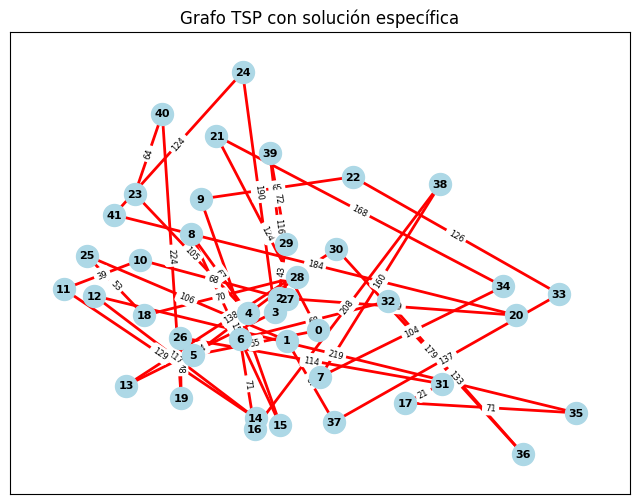

In [17]:
plot_tsp_solution(tsp_problem.edge_weights, crear_solucion(nodes))

/home/carlos/03MIAR-Algoritmos-de-Optimizacion-2025/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


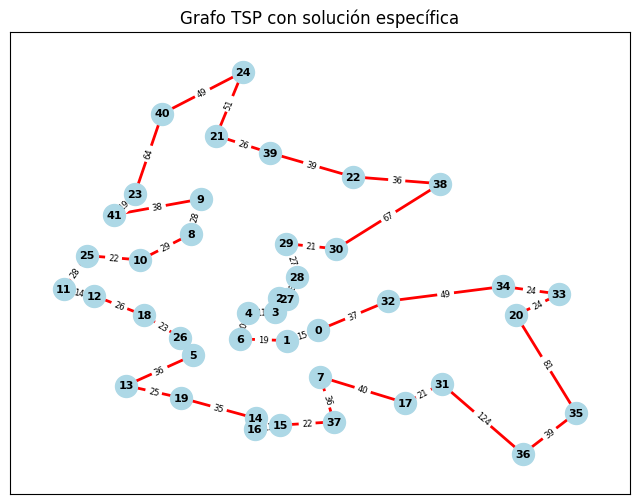

In [18]:
plot_tsp_solution(tsp_problem.edge_weights, mejor_solucion)

/home/carlos/03MIAR-Algoritmos-de-Optimizacion-2025/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


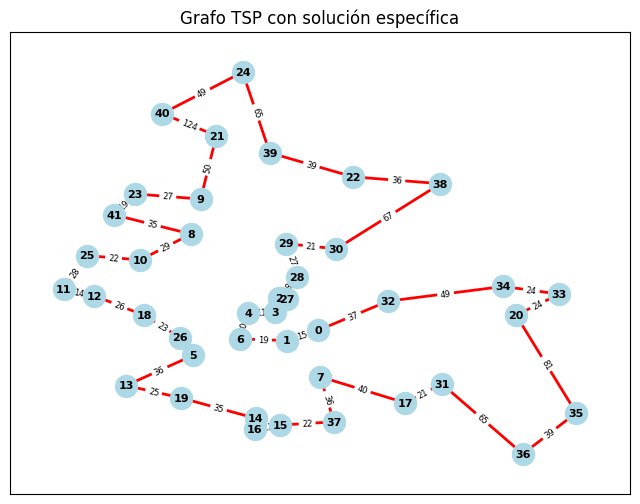

In [19]:
plot_tsp_solution(tsp_problem.edge_weights, sol)

# Nota sobre el uso de herramientas de IA generativa

En la elaboración de este notebook se emplearon herramientas de inteligencia artificial generativa de manera puntual y como apoyo conceptual, con los siguientes fines específicos:

* Orientación bibliográfica, mediante la sugerencia de artículos académicos y
 material de investigación relevantes, utilizados para contextualizar y explorar estrategias aplicables a algoritmos de búsqueda local con vecindades variables (Variable Neighborhood Search, VNS).
* Propuesta conceptual de esquemas de generación de vecindades para el algoritmo de Simulated Annealing, incluyendo configuraciones topológicamente más suaves, como la combinación probabilística de operadores (por ejemplo, 80% 2-opt y 20% insertion), empleadas como punto de partida para el diseño experimental.
* Sugerencia de variantes para el ajuste fino (fine-tuning) del cooling schedule en el algoritmo de Simulated Annealing, utilizadas como guía para la exploración de parámetros y su posterior validación empírica.

La modificación del código base, así como la implementación de las nuevas variantes y ajustes, es de autoría propia o se fundamenta en material proporcionado en clase y en recursos disponibles públicamente, los cuales han sido reinterpretados, adaptados y desarrollados para los objetivos de este trabajo.


# Bibliografía
* [1<a id="ref1"></a>] N. Mladenović y P. Hansen, "Variable neighborhood search, " Computers & Operations Research, vol. 24, no. 11, pp. 1097-1100, Nov. 1997.
* [2<a id="ref2"></a>] M. Lundy y A. Mees, "Convergence of an annealing algorithm," Mathematical Programming, vol. 34, no. 1, pp. 111–124, 1986.
* [3] Google, "Gemini," (versión Feb. 2026), [Modelo de Lenguaje Grande].